# 2. Bayes-i inferencia Stannel

Ehhez a PyStan csomagot fogjuk használni. Installáljunk föl és importáljunk be mindent, ami kelleni fog, és futtasuk le a szükséges beállításokat.

In [9]:
!pip install daft
!pip install pystan

In [59]:
import pystan
import daft
import numpy as np
import numpy.random as rnd
from scipy.stats import beta
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

## 2.1 Beta-Bernoulli modell 

Érmefeldobásként lehet elképzelni, ahol a rejtett változó, $b$, az érme aszimmetriáját jelöli 0 és 1 között.

$$p(b) = \mathrm{Beta}(\alpha,\beta)$$
$$p(x \mid b) = \mathrm{Bernoulli}(b)$$
$$ b \in \left[ 0,1 \right],\; x \in \lbrace 0,1 \rbrace$$

ahol a cinkeltség-változó legvalószínűbb értéke (modusa)

$$b_{max} = \frac{\alpha - 1}{\alpha + \beta - 2}$$

és a varianciája pedig

$$\mathrm{Var}\left[b\right] = \frac{\alpha \beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}$$

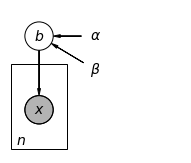

In [60]:
rc("font", family="serif", size=14)
pgm = daft.PGM((3, 2.5), origin=(0.15, 0.15))
pgm.add_node(daft.Node("x", r"$x$", 0.65, 0.9, observed=True))
pgm.add_node(daft.Node("b", r"$b$", 0.65, 2.2, observed=False))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 1.65, 2.2, observed=False, plot_params={"ec": "none"}))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.65, 1.6, observed=False, plot_params={"ec": "none"}))
pgm.add_plate(daft.Plate([0.15, 0.2, 1., 1.5],label=r"$n$"))
pgm.add_edge("b","x")
pgm.add_edge("alpha","b")
pgm.add_edge("beta","b")
pgm.render()

A Beta-Bernoulli modell rejtett változójának poszterior eloszlása $X = \lbrace x_1 \dots x_n \rbrace$ megfigyeléshalmazra a következő:

$$ p(b \mid X) = \frac{p(X \mid b) p(b)}{p(X)} = \frac{p(b) \prod_{i=1}^n p(x_i \mid b)}{\int_0^1 p(b) \prod_{i=1}^n p(x_i \mid b) \mathrm{d}b}$$

Az ilyen eloszlások bonyolultabb modellek esetén nem adhatók meg zárt formában, így ahhoz, hogy képet kapjunk a poszterior valószínűségekről, közelítő módszereket kell alkalmaznunk, amelyek vagy a variációs vagy a mintavételezéses megoldások közé fognak tartozni.

## 2.2 A Stan modelldefiníciós nyelv

A Stan független a pythontól, használható R, Matlab vagy parancssori környezetben is. Saját nyelve van valószínűségi generatív modellek definíciójára, amelyhez dokumentáció itt alálható: [http://mc-stan.org/users/documentation/index.html](http://mc-stan.org/users/documentation/index.html).

A Stan nyelvben a `data` blokk listázza azokat a mennyiségeket, amiket meg kell adni a modellnek inferencia esetén, azaz a megfigyeléseket és a hiperparamétereket, konstansokat. A `parameters` blokk listázza az összes olyan mennyiséget, ami fölött poszterior eloszlást akarunk kiszámolni. A `model` blokk adja meg azt, hogy hogyan kell mintákat generálni a prediktív eloszlásból, akár prior és likelihood eloszlások (ahol a `~` a mintavételezés jele), akár algoritmus formájában.

A PyStan csomag a Stan nyelv python interfésze, ennek használatához definiálhatjuk a Stan nyelvű modellt egy szöveges változóban vagy külön fileban is. Most úgy definiáljuk a Stan modellt, hogy a béta prior eloszlást a szokásos $\alpha, \beta$ paraméterek helyett a könnyebben értelmezhető, a legvalószínűbb értéket és az abban való bizonyosságot kódoló praméterekkel adhassuk meg.

In [44]:
beta_bernoulli_stan_code = """
data{
    int N;
    int x[N];
    real prior_concentration;
    real prior_mode;
}

parameters{
    real bias;
}

model{
    bias ~ beta( prior_mode * (prior_concentration-2) + 1,(1-prior_mode) * (prior_concentration-2) + 1);
    x ~ bernoulli(bias); 
}
"""

A modellt először le kell fordítanunk. A Stan nyelvű kód először C++ nyelvre, majd onnan bináris kódra fordul le, így gyorsabban fog futni, mint a soronként interpretált python kódok. Ez a lépés időigényesebb, de a fordítást csak akkor kell újrafuttatni, ha a modell kódját megváltoztatjuk, az egyes inferenciáknál nem. A lefordított modellt el is menthetjük és betölthetjük később.

In [45]:
sm = pystan.StanModel(model_code = beta_bernoulli_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6475f99822367a1d8df1fa3ab0297b64 NOW.


## 2.3 Az inferencia futtatása és kiértékelése

Hogy láthassuk, a modell definíciójában megadott prior eloszlások és a megfigyelések hogyan határozzák meg együtt a rejtett változó értékére vonatkozó következtetést, generáljunk szintetikus adatokat érmefeldobásokról. Mivel a plate definíciója szerint az adatok sorrendje nem számít, nem fontos, hogy véletlenszerű sorrendben legyenek, viszont szeretnénk meghatározni a fej (1) és írás (0) kimenetelek arányát és az adatok mennyiségét. Az adatokat és a prior paramétereket egy dictionary típusú asszociatív tömbben kell tárolni. 

A Stan a poszterior eloszlásokat mintavételezéssel közelíti (Hamiltonian Monte Carlo algoritmussal, amiről a későbbiekben szó lesz). Ezt a `sampling` függvény segítségével futtathatjuk (ez a lépés sokdimenziós modellek esetén sokáig tart, de a Beta-Bernoulli modell esetén gyors lesz). Egy objektumot kapunk vissza, amiből kinyerhetjük a poszterior mintákat. Ezeket hisztogramon ábrázolhatjuk. Próbálgassuk, hogy a prior eloszlás és az adatmennyiség változtatása hogyan hat a következtetés eredményére.

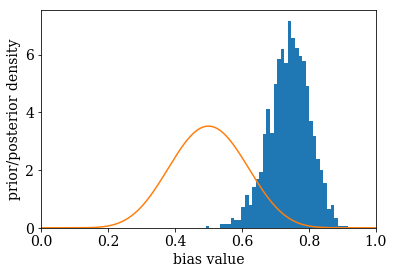

In [64]:
heads_ratio = 9  # should be an integer between 0 and 10
data_size = 30  # should be a multiple of 10
synthetic_data = ([1] * heads_ratio + [0] * (10-heads_ratio)) * int(data_size / 10)

# assemble data structure for Stan
data_dict = {
    'N': len(synthetic_data),
    'x': synthetic_data,
    'prior_concentration': 20,
    'prior_mode': 0.5
}

# run posterior sampling
fit = sm.sampling(data=data_dict, iter=2000, chains=2)
b_samples = fit.extract(permuted=True)['bias']

# plot histogram of samples
plt.hist(b_samples, bins=40, normed=True)
plt.xlim([0, 1])
# plot prior density function
xgrid = np.linspace(0,1,1000)
plt.plot(xgrid,beta.pdf(xgrid,data_dict['prior_mode']*(data_dict['prior_concentration']-2)+1,(1-data_dict['prior_mode'])*(data_dict['prior_concentration']-2)+1))
plt.xlabel('bias value')
plt.ylabel('prior/posterior density')